# Deep Learning Time Series Forecasting with DeepAR

## Overview
This notebook implements a streamlined time series forecasting pipeline using the **DeepAR (Deep AutoRegressive)** model from GluonTS.

## Workflow
1. **Data Loading**: Ingesting prepared Rossmann Store Sales data.
2. **Feature Engineering**: Cleaning series and encoding categorical variables.
3. **Data Preparation**: formatting data into GluonTS `ListDataset` format.
4. **Model Training**: Training a DeepAR Estimator on the full dataset.
5. **Evaluation**: Calculating key performance metrics (**MAPE, MAE, sMAPE, MASE, RMSE**).
6. **Visualization**: Plotting forecasts against actuals and analyzing error distributions.

## 1. Environment Setup

Importing necessary libraries, setting random seeds for reproducibility, and configuring the environment.

In [1]:
%pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 996.5 kB/s eta 0:00:00 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 33.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 69.1 MB/s eta 0:00:0000:01:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 73.7 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 645.7 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 13.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 798.9 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 12.3 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 13.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━

In [1]:
# Core dependencies
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from typing import List, Tuple, Dict, Optional
from tqdm.auto import tqdm

# Deep learning and time series libraries
import torch
from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName
from gluonts.torch.model.deepar import DeepAREstimator
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.torch.distributions import NegativeBinomialOutput

# Scikit-learn for additional metric verification
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Set display options
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.6f}'.format)

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

# Set random seeds
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.2.2+cu121
CUDA available: True


## 2. Configuration

We define a central configuration class to manage hyperparameters, file paths, and forecast settings (prediction length, frequency, etc.).

In [14]:
class Config:
    """Central configuration for the DeepAR forecasting pipeline."""
    
    # Data paths
    DATA_PATH = "./data"
    TRAIN_FILE = "train.csv"
    OUTPUT_DIR = "./deepar_outputs"
    PLOTS_DIR = f"{OUTPUT_DIR}/plots"
    
    # Time series parameters
    PREDICTION_LENGTH = 48
    FREQ = "D"
    SEASONALITY_PERIOD = 7
    
    # Validation settings
    VALIDATION_MODE = True
    
    # DeepAR hyperparameters
    DEEPAR_CONFIG = {
        'context_length': 2 * PREDICTION_LENGTH,
        'num_layers': 3,
        'hidden_size': 64,
        'dropout_rate': 0.1,
        'lr': 1e-3,
        'epochs': 30,
        'batch_size': 32,
        'num_batches_per_epoch': 400,
    }
    
    # Evaluation settings
    NUM_SAMPLES = 100
    QUANTILES = [0.1, 0.5, 0.9]
    
    # Visualization settings
    NUM_PLOTS = 3
    PLOT_LENGTH = 200

# Create output directories
Path(Config.OUTPUT_DIR).mkdir(parents=True, exist_ok=True)
Path(Config.PLOTS_DIR).mkdir(parents=True, exist_ok=True)
print(f"Config loaded. Forecasting horizon: {Config.PREDICTION_LENGTH} days.")

Config loaded. Forecasting horizon: 48 days.


## 3. Data Loading

Loading the CSV data and converting the date column to the correct datetime format.

In [3]:
def load_and_merge_data(data_path: str, train_file: str, store_file: str) -> pd.DataFrame:
    path = Path(data_path)
    
    print("Loading data...")
    train_df = pd.read_csv(path / train_file)
    store_df = pd.read_csv(path / store_file)
    
    # Convert Date
    train_df['Date'] = pd.to_datetime(train_df['Date'])
    
    # Merge Store Metadata (Static Features) into the main dataframe
    print("Merging store metadata...")
    # Merging ensures every row has the store's specific attributes (Type, Assortment, etc.)
    df = pd.merge(train_df, store_df, on='Store', how='left')
    
    # Fill NaNs in CompetitionDistance (common in Rossmann) with median or 0
    df['CompetitionDistance'] = df['CompetitionDistance'].fillna(df['CompetitionDistance'].median())
    
    print(f"Merged Data loaded: {df.shape[0]:,} rows, {df.shape[1]} columns")
    return df

# Usage
# Assuming 'store.csv' is in the same directory
df = load_and_merge_data(Config.DATA_PATH, Config.TRAIN_FILE, "store.csv")

Loading data...
Merging store metadata...
Merged Data loaded: 1,017,209 rows, 18 columns


## 4. Feature Engineering

### 4.1 Cleaning and Encoding
1. **Clean Time Series**: We remove store data that is incomplete to ensure all series have the same length for batch processing.
2. **Encode Categoricals**: We convert categorical features (like Store ID, State, etc.) into numerical codes required by the DeepAR embedding layers.

In [4]:
# 1. Clean Data (Remove incomplete series)
def clean_time_series(df: pd.DataFrame, id_col: str = 'Store') -> pd.DataFrame:
    target_length = df[id_col].value_counts().max()
    print(f"Target series length: {target_length}")
    
    df_clean = df.groupby(id_col).filter(lambda x: len(x) == target_length)
    df_clean = df_clean.sort_values(['Date', id_col]).reset_index(drop=True)
    df_clean = df_clean.loc[:, ~df_clean.columns.str.contains('^Unnamed', case=False)]
    
    print(f"Cleaned dataset: {df_clean['Store'].nunique()} stores remaining.")
    return df_clean

df = clean_time_series(df)

# 2. Encode Categoricals
def encode_all_features(df: pd.DataFrame) -> Tuple[pd.DataFrame, Dict[str, int], List[int]]:
    # We now have more static categorical features from store.csv
    static_cols = ['Store', 'StoreType', 'Assortment'] 
    
    df_encoded = df.copy()
    cardinalities = {}
    cardinality_list = []
    
    print("Encoding static features...")
    for var in static_cols:
        # Convert to category and get codes
        df_encoded[var] = df_encoded[var].astype('category')
        df_encoded[f'{var}_cat'] = df_encoded[var].cat.codes
        
        # Calculate cardinality (how many unique values)
        unique_count = df_encoded[var].nunique()
        cardinalities[var] = unique_count
        cardinality_list.append(unique_count)
        
    return df_encoded, cardinalities, cardinality_list

df, cardinalities, static_cardinalities = encode_all_features(df)

print(f"Static features encoded: ['Store', 'StoreType', 'Assortment']")
print(f"Cardinalities: {static_cardinalities}") 
# Output might look like [1115, 4, 3] (1115 stores, 4 types, 3 assortments)

Target series length: 942
Cleaned dataset: 934 stores remaining.
Encoding static features...
Static features encoded: ['Store', 'StoreType', 'Assortment']
Cardinalities: [934, 4, 3]


## 5. Data Preparation

### 5.1 Creating GluonTS Datasets
DeepAR requires data in a specific dictionary format (or `ListDataset`). We prepare:
1. **Train Dataset**: Excluding the last `prediction_length` days.
2. **Test Dataset**: Containing the full data (the model will mask the end automatically during testing).
3. **Static Features**: Adding Store ID as a static categorical feature.

In [5]:
# 1. Prepare Target Arrays
def prepare_target_values(df: pd.DataFrame, prediction_length: int) -> Tuple[np.ndarray, np.ndarray]:
    num_series = df['Store'].nunique()
    series_length = df['Store'].value_counts().iloc[0]
    
    # Shape: (num_series, time_steps)
    target_values = df['Sales'].values.reshape(series_length, num_series).T
    
    # Split for validation
    train_targets = target_values[:, :-prediction_length]
    test_targets = target_values  # Test uses full length
    
    return train_targets, test_targets

train_target_values, test_target_values = prepare_target_values(df, Config.PREDICTION_LENGTH)

# 2. Create GluonTS ListDatasets
print("Creating GluonTS ListDatasets...")

# Prepare static features array: Shape (num_series, num_static_features)
# We group by store and take the first value (since they are static, they don't change)
static_features_df = df.groupby('Store')[['Store_cat', 'StoreType_cat', 'Assortment_cat']].first()
static_feat_array = static_features_df.values # Shape: (1115, 3)

print("Creating enhanced GluonTS Datasets...")

train_ds = ListDataset(
    [
        {
            FieldName.TARGET: target,
            FieldName.START: df['Date'].iloc[0],
            # NOW PASSING ALL 3 STATIC FEATURES
            FieldName.FEAT_STATIC_CAT: static_feat_array[i] 
        }
        for i, target in enumerate(train_target_values)
    ],
    freq=Config.FREQ
)

test_ds = ListDataset(
    [
        {
            FieldName.TARGET: target,
            FieldName.START: df['Date'].iloc[0],
            # NOW PASSING ALL 3 STATIC FEATURES
            FieldName.FEAT_STATIC_CAT: static_feat_array[i]
        }
        for i, target in enumerate(test_target_values)
    ],
    freq=Config.FREQ
)

print(f"Train dataset size: {len(train_ds)}")
print(f"Test dataset size: {len(test_ds)}")

Creating GluonTS ListDatasets...
Creating enhanced GluonTS Datasets...
Train dataset size: 934
Test dataset size: 934


## 6. Model Training (DeepAR)

We initialize and train the `DeepAREstimator`. 
* **NegativeBinomialOutput**: Used because Sales data is count-based (non-negative).
* **Context Length**: How far back the model looks to make a prediction.

In [6]:
print("\n" + "="*80)
print("TRAINING ENHANCED DEEPAR MODEL")
print("="*80)

# Initialize DeepAR Estimator
estimator = DeepAREstimator(
    freq=Config.FREQ,
    prediction_length=Config.PREDICTION_LENGTH,
    context_length=Config.DEEPAR_CONFIG['context_length'],
    num_layers=Config.DEEPAR_CONFIG['num_layers'],
    hidden_size=Config.DEEPAR_CONFIG['hidden_size'],
    dropout_rate=Config.DEEPAR_CONFIG['dropout_rate'],
    lr=Config.DEEPAR_CONFIG['lr'],
    batch_size=Config.DEEPAR_CONFIG['batch_size'],
    num_batches_per_epoch=Config.DEEPAR_CONFIG['num_batches_per_epoch'],
    trainer_kwargs={"max_epochs": Config.DEEPAR_CONFIG['epochs'], "accelerator": "auto"},
    distr_output=NegativeBinomialOutput(),
    
    # CRITICAL UPDATE: Pass list of cardinalities for [Store, StoreType, Assortment]
    cardinality=static_cardinalities 
)

print("Starting training...")
deepar_predictor = estimator.train(train_ds, num_workers=0)
print("DeepAR training completed!")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



TRAINING ENHANCED DEEPAR MODEL
Starting training...


You are using a CUDA device ('NVIDIA GeForce RTX 3050 Ti Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type        | Params | Mode  | In sizes                                                         | Out sizes   
--------------------------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 93.1 K | train | [[1, 1], [1, 1], [1, 1188, 4], [1, 1188], [1, 1188], [1, 48, 4]] | [1, 100, 48]
--------------------------------------------------------------------------------------------------------------------------------
93.1 K    Trainable params
0         Non-trainable params
93.1 K    Total p

Epoch 0: |          | 400/? [00:19<00:00, 20.44it/s, v_num=1, train_loss=46.80]

Epoch 0, global step 400: 'train_loss' reached 46.83627 (best 46.83627), saving model to '/media/thsondev/SSD/Code/deep-ar-rossmann-sales/lightning_logs/version_1/checkpoints/epoch=0-step=400.ckpt' as top 1


Epoch 1: |          | 400/? [00:23<00:00, 17.12it/s, v_num=1, train_loss=21.20]

Epoch 1, global step 800: 'train_loss' reached 21.15867 (best 21.15867), saving model to '/media/thsondev/SSD/Code/deep-ar-rossmann-sales/lightning_logs/version_1/checkpoints/epoch=1-step=800.ckpt' as top 1


Epoch 2: |          | 400/? [00:23<00:00, 16.97it/s, v_num=1, train_loss=26.60]

Epoch 2, global step 1200: 'train_loss' was not in top 1


Epoch 3: |          | 400/? [00:24<00:00, 16.54it/s, v_num=1, train_loss=18.90]

Epoch 3, global step 1600: 'train_loss' reached 18.87642 (best 18.87642), saving model to '/media/thsondev/SSD/Code/deep-ar-rossmann-sales/lightning_logs/version_1/checkpoints/epoch=3-step=1600.ckpt' as top 1


Epoch 4: |          | 400/? [00:22<00:00, 18.05it/s, v_num=1, train_loss=14.60]

Epoch 4, global step 2000: 'train_loss' reached 14.59656 (best 14.59656), saving model to '/media/thsondev/SSD/Code/deep-ar-rossmann-sales/lightning_logs/version_1/checkpoints/epoch=4-step=2000.ckpt' as top 1


Epoch 5: |          | 400/? [00:23<00:00, 17.23it/s, v_num=1, train_loss=8.240]

Epoch 5, global step 2400: 'train_loss' reached 8.24041 (best 8.24041), saving model to '/media/thsondev/SSD/Code/deep-ar-rossmann-sales/lightning_logs/version_1/checkpoints/epoch=5-step=2400.ckpt' as top 1


Epoch 6: |          | 400/? [00:22<00:00, 17.70it/s, v_num=1, train_loss=6.720]

Epoch 6, global step 2800: 'train_loss' reached 6.72023 (best 6.72023), saving model to '/media/thsondev/SSD/Code/deep-ar-rossmann-sales/lightning_logs/version_1/checkpoints/epoch=6-step=2800.ckpt' as top 1


Epoch 7: |          | 400/? [00:23<00:00, 16.89it/s, v_num=1, train_loss=6.610]

Epoch 7, global step 3200: 'train_loss' reached 6.61075 (best 6.61075), saving model to '/media/thsondev/SSD/Code/deep-ar-rossmann-sales/lightning_logs/version_1/checkpoints/epoch=7-step=3200.ckpt' as top 1


Epoch 8: |          | 400/? [00:23<00:00, 17.28it/s, v_num=1, train_loss=6.580]

Epoch 8, global step 3600: 'train_loss' reached 6.58164 (best 6.58164), saving model to '/media/thsondev/SSD/Code/deep-ar-rossmann-sales/lightning_logs/version_1/checkpoints/epoch=8-step=3600.ckpt' as top 1


Epoch 9: |          | 400/? [00:22<00:00, 18.10it/s, v_num=1, train_loss=6.960]

Epoch 9, global step 4000: 'train_loss' was not in top 1


Epoch 10: |          | 400/? [00:16<00:00, 23.53it/s, v_num=1, train_loss=6.520]

Epoch 10, global step 4400: 'train_loss' reached 6.52409 (best 6.52409), saving model to '/media/thsondev/SSD/Code/deep-ar-rossmann-sales/lightning_logs/version_1/checkpoints/epoch=10-step=4400.ckpt' as top 1


Epoch 11: |          | 400/? [00:21<00:00, 18.21it/s, v_num=1, train_loss=6.510]

Epoch 11, global step 4800: 'train_loss' reached 6.50610 (best 6.50610), saving model to '/media/thsondev/SSD/Code/deep-ar-rossmann-sales/lightning_logs/version_1/checkpoints/epoch=11-step=4800.ckpt' as top 1


Epoch 12: |          | 400/? [00:23<00:00, 16.81it/s, v_num=1, train_loss=6.490]

Epoch 12, global step 5200: 'train_loss' reached 6.49411 (best 6.49411), saving model to '/media/thsondev/SSD/Code/deep-ar-rossmann-sales/lightning_logs/version_1/checkpoints/epoch=12-step=5200.ckpt' as top 1


Epoch 13: |          | 400/? [00:23<00:00, 17.19it/s, v_num=1, train_loss=6.470]

Epoch 13, global step 5600: 'train_loss' reached 6.47459 (best 6.47459), saving model to '/media/thsondev/SSD/Code/deep-ar-rossmann-sales/lightning_logs/version_1/checkpoints/epoch=13-step=5600.ckpt' as top 1


Epoch 14: |          | 400/? [00:23<00:00, 17.38it/s, v_num=1, train_loss=6.460]

Epoch 14, global step 6000: 'train_loss' reached 6.46397 (best 6.46397), saving model to '/media/thsondev/SSD/Code/deep-ar-rossmann-sales/lightning_logs/version_1/checkpoints/epoch=14-step=6000.ckpt' as top 1


Epoch 15: |          | 400/? [00:22<00:00, 17.77it/s, v_num=1, train_loss=6.610]

Epoch 15, global step 6400: 'train_loss' was not in top 1


Epoch 16: |          | 400/? [00:23<00:00, 17.15it/s, v_num=1, train_loss=6.430]

Epoch 16, global step 6800: 'train_loss' reached 6.42973 (best 6.42973), saving model to '/media/thsondev/SSD/Code/deep-ar-rossmann-sales/lightning_logs/version_1/checkpoints/epoch=16-step=6800.ckpt' as top 1


Epoch 17: |          | 400/? [00:22<00:00, 17.83it/s, v_num=1, train_loss=6.430]

Epoch 17, global step 7200: 'train_loss' was not in top 1


Epoch 18: |          | 400/? [00:22<00:00, 17.84it/s, v_num=1, train_loss=6.430]

Epoch 18, global step 7600: 'train_loss' was not in top 1


Epoch 19: |          | 400/? [00:23<00:00, 17.05it/s, v_num=1, train_loss=6.410]

Epoch 19, global step 8000: 'train_loss' reached 6.41414 (best 6.41414), saving model to '/media/thsondev/SSD/Code/deep-ar-rossmann-sales/lightning_logs/version_1/checkpoints/epoch=19-step=8000.ckpt' as top 1


Epoch 20: |          | 400/? [00:22<00:00, 17.69it/s, v_num=1, train_loss=6.400]

Epoch 20, global step 8400: 'train_loss' reached 6.39571 (best 6.39571), saving model to '/media/thsondev/SSD/Code/deep-ar-rossmann-sales/lightning_logs/version_1/checkpoints/epoch=20-step=8400.ckpt' as top 1


Epoch 21: |          | 400/? [00:23<00:00, 17.26it/s, v_num=1, train_loss=6.390]

Epoch 21, global step 8800: 'train_loss' reached 6.38790 (best 6.38790), saving model to '/media/thsondev/SSD/Code/deep-ar-rossmann-sales/lightning_logs/version_1/checkpoints/epoch=21-step=8800.ckpt' as top 1


Epoch 22: |          | 400/? [00:23<00:00, 17.38it/s, v_num=1, train_loss=6.370]

Epoch 22, global step 9200: 'train_loss' reached 6.36929 (best 6.36929), saving model to '/media/thsondev/SSD/Code/deep-ar-rossmann-sales/lightning_logs/version_1/checkpoints/epoch=22-step=9200.ckpt' as top 1


Epoch 23: |          | 400/? [00:25<00:00, 15.92it/s, v_num=1, train_loss=6.370]

Epoch 23, global step 9600: 'train_loss' was not in top 1


Epoch 24: |          | 400/? [00:22<00:00, 17.47it/s, v_num=1, train_loss=6.380]

Epoch 24, global step 10000: 'train_loss' was not in top 1


Epoch 25: |          | 400/? [00:23<00:00, 16.99it/s, v_num=1, train_loss=8.230]

Epoch 25, global step 10400: 'train_loss' was not in top 1


Epoch 26: |          | 400/? [00:23<00:00, 17.11it/s, v_num=1, train_loss=6.370]

Epoch 26, global step 10800: 'train_loss' reached 6.36806 (best 6.36806), saving model to '/media/thsondev/SSD/Code/deep-ar-rossmann-sales/lightning_logs/version_1/checkpoints/epoch=26-step=10800.ckpt' as top 1


Epoch 27: |          | 400/? [00:19<00:00, 20.15it/s, v_num=1, train_loss=6.340]

Epoch 27, global step 11200: 'train_loss' reached 6.34077 (best 6.34077), saving model to '/media/thsondev/SSD/Code/deep-ar-rossmann-sales/lightning_logs/version_1/checkpoints/epoch=27-step=11200.ckpt' as top 1


Epoch 28: |          | 400/? [00:18<00:00, 21.96it/s, v_num=1, train_loss=6.350]

Epoch 28, global step 11600: 'train_loss' was not in top 1


Epoch 29: |          | 400/? [00:18<00:00, 21.24it/s, v_num=1, train_loss=6.350]

Epoch 29, global step 12000: 'train_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: |          | 400/? [00:18<00:00, 21.21it/s, v_num=1, train_loss=6.350]
DeepAR training completed!


## 7. Evaluation

We generate forecasts for the test set and calculate the following key metrics:
* **MAE** (Mean Absolute Error): Average magnitude of errors.
* **MAPE** (Mean Absolute Percentage Error): Error relative to the true value.
* **sMAPE** (Symmetric MAPE): A more stable percentage error, bounded between 0% and 200%.
* **MASE** (Mean Absolute Scaled Error): Measures performance relative to a naive baseline (useful for seasonality).
* **RMSE** (Root Mean Squared Error): Penalizes large errors more strongly and highlights volatility or outliers in predictions.

In [15]:
print("EVALUATING MODEL PERFORMANCE\n")

# Generate forecasts
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,
    predictor=deepar_predictor,
    num_samples=Config.NUM_SAMPLES
)

print("Processing forecasts...")
deepar_forecasts = list(tqdm(forecast_it, total=len(test_ds)))
deepar_tss = list(tqdm(ts_it, total=len(test_ds)))

# Calculate Metrics using GluonTS Evaluator
evaluator = Evaluator(quantiles=Config.QUANTILES, seasonality=Config.SEASONALITY_PERIOD)
agg_metrics, item_metrics = evaluator(iter(deepar_tss), iter(deepar_forecasts))

# PER-STORE METRICS
# Map integer index back to actual Store IDs
unique_store_ids = df['Store'].unique()
item_metrics['Store_ID'] = unique_store_ids[:len(item_metrics)]

# Calculate MAE (Mean Absolute Error)
item_metrics['MAE'] = item_metrics['abs_error'] / Config.PREDICTION_LENGTH

# Calculate RMSE (Root Mean Squared Error) from MSE
item_metrics['RMSE'] = np.sqrt(item_metrics['MSE'])

per_store_df = item_metrics[['Store_ID', 'MAE', 'MAPE', 'sMAPE', 'MASE', 'RMSE']].copy()

# Save Per-Store Metrics
per_store_path = Path(Config.OUTPUT_DIR) / 'deepar_per_store_metrics.csv'
per_store_df.to_csv(per_store_path, index=False)
print(f"\nPer-store metrics saved to: {per_store_path}")

print("\nGLOBAL PERFORMANCE METRICS")

# Calculate Global MAE
total_predictions = len(test_ds) * Config.PREDICTION_LENGTH
global_mae = agg_metrics['abs_error'] / total_predictions

final_metrics = {
    "MAE": global_mae,
    "MAPE": agg_metrics['MAPE'],
    "sMAPE": agg_metrics['sMAPE'],
    "MASE": agg_metrics['MASE'],
    "RMSE": agg_metrics['RMSE']
}

metrics_df = pd.DataFrame([final_metrics])
display(metrics_df.style.format("{:.4f}").background_gradient(axis=1))

# Save Global Metrics
metrics_df.to_csv(Path(Config.OUTPUT_DIR) / 'deepar_key_metrics.csv', index=False)
print(f"Detailed global metrics saved to {Config.OUTPUT_DIR}")

EVALUATING MODEL PERFORMANCE

Processing forecasts...


100%|██████████| 934/934 [00:00<00:00, 12408.04it/s]
Running evaluation: 934it [00:00, 23963.35it/s]



Per-store metrics saved to: deepar_outputs/deepar_per_store_metrics.csv

GLOBAL PERFORMANCE METRICS


,MAE,MAPE,sMAPE,MASE,RMSE
0,796.5113,0.1322,0.1528,0.3965,1417.1631


Detailed global metrics saved to ./deepar_outputs


## 8. Visualization

### 8.1 Forecast Plots
Visualizing the model's predictions against ground truth for random samples, including confidence intervals.


Plotting forecasts for stores: [1, 30, 100]...


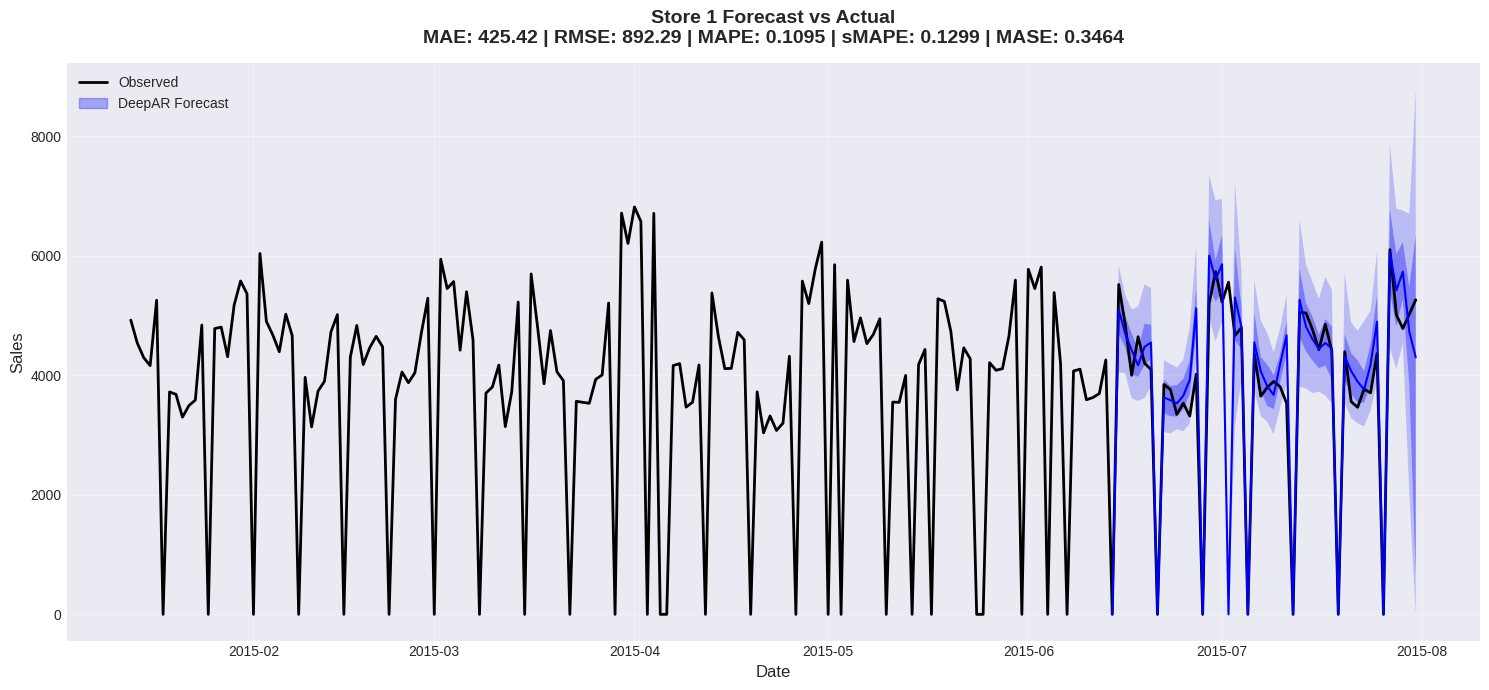

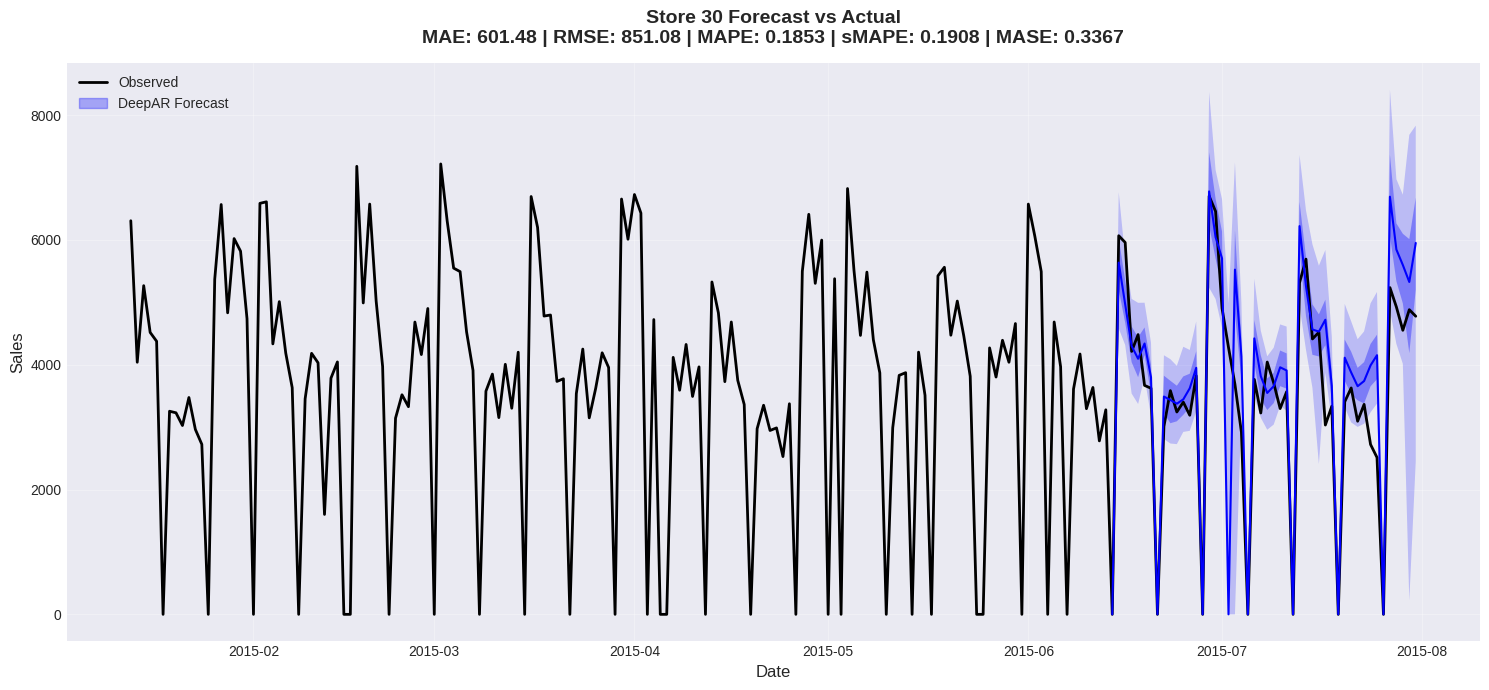

In [16]:
# Enter the specific Store IDs you want to visualize
CUSTOM_STORE_IDS = [1, 30, 100] 

def plot_forecast_with_metrics(ts, forecast, prediction_length: int, store_id: int, 
                               metrics_row: pd.Series, plot_length: int = 200, 
                               save_path: Optional[Path] = None):
    fig, ax = plt.subplots(figsize=(15, 7))
    
    # 1. Prepare Data
    if hasattr(ts.index, 'to_timestamp'):
        ts_index = ts.index.to_timestamp()
    else:
        ts_index = ts.index
    ts_values = ts.to_numpy()
    
    # 2. Format Metrics for Title
    # We pull the pre-calculated metrics from the row we passed in
    metrics_str = (f"MAE: {metrics_row['MAE']:.2f} | RMSE: {metrics_row['RMSE']:.2f} | "
                   f"MAPE: {metrics_row['MAPE']:.4f} | sMAPE: {metrics_row['sMAPE']:.4f} | "
                   f"MASE: {metrics_row['MASE']:.4f}")

    # 3. Plotting
    start_idx = max(0, len(ts_values) - plot_length)
    
    # Plot Actuals
    ax.plot(ts_index[start_idx:], ts_values[start_idx:], 
            label='Observed', color='black', linewidth=2)
    
    # Plot Forecast
    forecast.plot(ax=ax, color='blue')
    
    # Manual Legend
    import matplotlib.patches as mpatches
    handles, labels = ax.get_legend_handles_labels()
    forecast_patch = mpatches.Patch(color='blue', alpha=0.3, label='DeepAR Forecast')
    handles.append(forecast_patch)
    
    # 4. Formatting
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Sales', fontsize=12)
    
    # Title with Store ID and Specific Metrics
    ax.set_title(f'Store {store_id} Forecast vs Actual\n{metrics_str}', 
                 fontsize=14, fontweight='bold', pad=15)
    
    ax.legend(handles=handles, loc='upper left')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()

print(f"\nPlotting forecasts for stores: {CUSTOM_STORE_IDS}...")

# We need to map Store ID -> Array Index
# unique_store_ids was created in the Eval cell
store_id_map = {sid: idx for idx, sid in enumerate(unique_store_ids)}

for store_id in CUSTOM_STORE_IDS:
    if store_id not in store_id_map:
        print(f"Warning: Store {store_id} not found in dataset. Skipping.")
        continue
        
    # Get the integer index for this store
    idx = store_id_map[store_id]
    
    # Get the metrics row for this specific store
    # per_store_df was created in the Eval cell
    store_metrics = per_store_df[per_store_df['Store_ID'] == store_id].iloc[0]
    
    plot_forecast_with_metrics(
        ts=deepar_tss[idx],
        forecast=deepar_forecasts[idx],
        prediction_length=Config.PREDICTION_LENGTH,
        store_id=store_id,
        metrics_row=store_metrics,
        plot_length=Config.PLOT_LENGTH,
        save_path=Path(Config.PLOTS_DIR) / f'deepar_forecast_store_{store_id}.png'
    )

### 8.2 Error Distribution
Analyzing the residuals (Actual - Predicted) to check for bias. A well-performing model should have errors centered around zero.

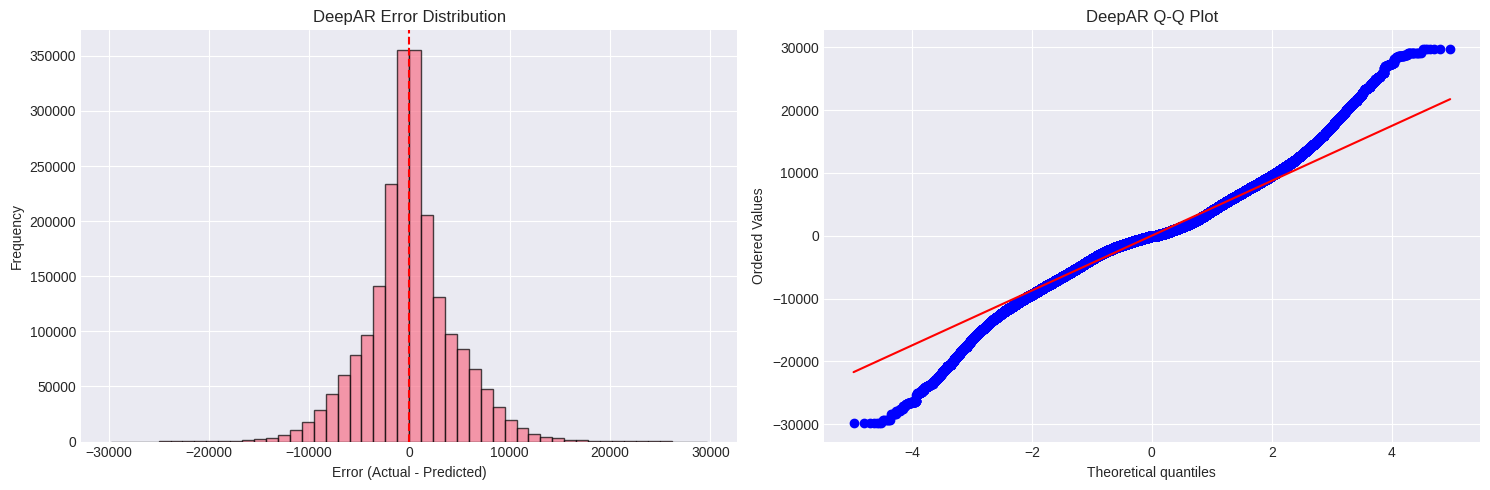

Mean Error (Bias): 20.79
Standard Deviation: 4418.06


In [17]:
def plot_error_distribution(forecasts, tss, model_name="DeepAR"):
    errors = []
    for ts, forecast in zip(tss, forecasts):
        # Align forecast with ground truth
        # Ensure we are comparing the same time periods
        true_values = ts.to_numpy()[-Config.PREDICTION_LENGTH:]
        pred_values = forecast.mean
        
        # Calculate error and append
        # flatten() ensures we add individual floats, not arrays, avoiding nested shapes
        error = true_values - pred_values
        errors.extend(error.flatten())
    
    # Convert to numpy array and ensure 1D
    errors = np.array(errors)
    
    # Remove NaNs if any (DeepAR can sometimes produce NaNs in empty windows)
    errors = errors[~np.isnan(errors)]
    
    # Check if we have data to plot
    if len(errors) == 0:
        print("No valid errors to plot.")
        return
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Histogram
    axes[0].hist(errors, bins=50, edgecolor='black', alpha=0.7)
    axes[0].axvline(0, color='red', linestyle='--')
    axes[0].set_xlabel('Error (Actual - Predicted)')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title(f'{model_name} Error Distribution')
    
    # Q-Q plot
    from scipy import stats
    stats.probplot(errors, dist="norm", plot=axes[1])
    axes[1].set_title(f'{model_name} Q-Q Plot')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Mean Error (Bias): {errors.mean():.2f}")
    print(f"Standard Deviation: {errors.std():.2f}")

plot_error_distribution(deepar_forecasts, deepar_tss)